# Simulated Annealing Demo

Skrypt przedstawia przykładową implementację algorytmu symulowanego wyżarzania (ang. Simulated Annealing, SA) i jego zastosowanie do rozwiązywania problemu Quadratic Assignment Problem (QAP). Problem jest dokładnie opisany m.in. w pracy Burkarda i innych [1]. Popularne instancje problemu QAP można znaleźć w bibliotece QAPLib [2]. Skrypt skupia się na rozwiązywaniu instancji NUG12 [3], w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu.

Literatura:

[1]  Burkard, R., Cela, E., Pardalos, P., Pitsoulis, L., "The Quadratic Assignment Problem", http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.217.1914

[2] QAPLIB, https://qaplib.mgi.polymtl.ca/

[3] NUG12, https://qaplib.mgi.polymtl.ca/data.d/nug12.dat

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request

%matplotlib inline

In [2]:
QAP_INSTANCE_URL = 'https://qaplib.mgi.polymtl.ca/data.d/nug12.dat'

## Reading input data

In [3]:
def read_instance(QAP_INSTANCE_URL):
    qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)
    
    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])
    print('Problem size: %d' % n)

    A = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Flow matrix:\n', A)
    
    B = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Distance matrix:\n', B)

    return n,A,B

n, A, B= read_instance(QAP_INSTANCE_URL)

Problem size: 12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  

## Objective function

In [4]:
def qap_objective_function(p,n,A,B):
    s = 0.0
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum() #flow dla obiektu i * dystans po przeniesieniu go do pozycji zdefiniowanej w p[i]
    return s


In [5]:
p = [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]
'''

p =  permutacja lokalizacji dla obiektów tzn. obiekt 0 do lokalizacji 11 itd.
A = flow między obiektami
B = dystans miedzy lokalizacjami

'''
print(qap_objective_function(p, n, A, B), p)

578.0 [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]


## Random Sampling

In [6]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = qap_objective_function(permutations[i, :], n, A, B)

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(qap_objective_function(p, n, A, B), p)

33.348788022994995
586.0 [11  8 10  2  3  6  7  0  4  5  9  1]


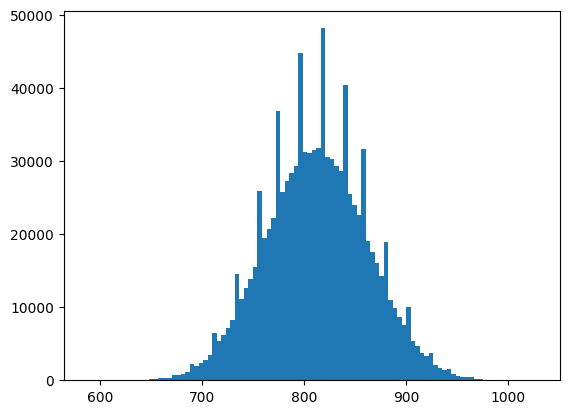

812.024432 49.69751449597229


In [7]:
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

## Simulated Annealing

In [8]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

21.001132249832153 578.0


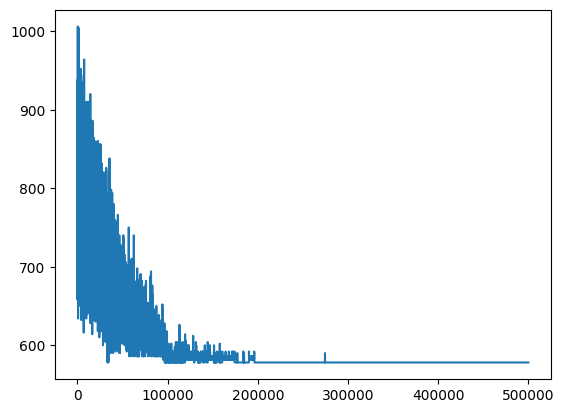

In [9]:
T = 500000
radius = 1
alpha = 1.0

def simulated_annealing(T,radius,alpha, n, A, B):
    t0 = time.time()
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p, n, A, B)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q, n, A, B)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    
    print(time.time() - t0, costs.min())

    return costs

costs = simulated_annealing(T, radius, alpha, n, A, B)

plt.figure()
plt.plot(costs)
plt.show()

Problem size: 14
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.  1.  0.  2.  5.]
 [ 1.  2.  2.  1.  0.  3.  5.  5.  5.  1.  0.  3.  0.  5.]
 [ 0.  2.  0.  1.  3.  0.

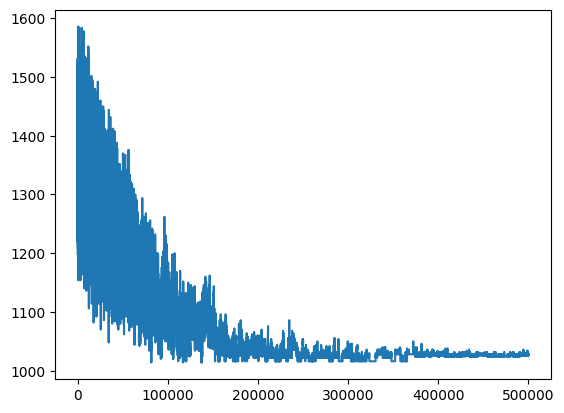

In [10]:
QAP_INSTANCE_URL = 'https://qaplib.mgi.polymtl.ca/data.d/nug14.dat'
n, A, B = read_instance(QAP_INSTANCE_URL)

T = 500000
radius = 1
alpha = 0.5

costs = simulated_annealing(T, radius, alpha, n, A, B)

plt.figure()
plt.plot(costs)
plt.show()

Problem size: 21
Flow matrix:
 [[0. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 7. 2. 3. 4. 5. 6. 7. 8.]
 [1. 0. 1. 2. 3. 4. 5. 2. 1. 2. 3. 4. 5. 6. 3. 2. 3. 4. 5. 6. 7.]
 [2. 1. 0. 1. 2. 3. 4. 3. 2. 1. 2. 3. 4. 5. 4. 3. 2. 3. 4. 5. 6.]
 [3. 2. 1. 0. 1. 2. 3. 4. 3. 2. 1. 2. 3. 4. 5. 4. 3. 2. 3. 4. 5.]
 [4. 3. 2. 1. 0. 1. 2. 5. 4. 3. 2. 1. 2. 3. 6. 5. 4. 3. 2. 3. 4.]
 [5. 4. 3. 2. 1. 0. 1. 6. 5. 4. 3. 2. 1. 2. 7. 6. 5. 4. 3. 2. 3.]
 [6. 5. 4. 3. 2. 1. 0. 7. 6. 5. 4. 3. 2. 1. 8. 7. 6. 5. 4. 3. 2.]
 [1. 2. 3. 4. 5. 6. 7. 0. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 7.]
 [2. 1. 2. 3. 4. 5. 6. 1. 0. 1. 2. 3. 4. 5. 2. 1. 2. 3. 4. 5. 6.]
 [3. 2. 1. 2. 3. 4. 5. 2. 1. 0. 1. 2. 3. 4. 3. 2. 1. 2. 3. 4. 5.]
 [4. 3. 2. 1. 2. 3. 4. 3. 2. 1. 0. 1. 2. 3. 4. 3. 2. 1. 2. 3. 4.]
 [5. 4. 3. 2. 1. 2. 3. 4. 3. 2. 1. 0. 1. 2. 5. 4. 3. 2. 1. 2. 3.]
 [6. 5. 4. 3. 2. 1. 2. 5. 4. 3. 2. 1. 0. 1. 6. 5. 4. 3. 2. 1. 2.]
 [7. 6. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 1. 0. 7. 6. 5. 4. 3. 2. 1.]
 [2. 3. 4. 5. 6. 7. 8. 1. 2. 3. 4. 5. 6. 7. 0

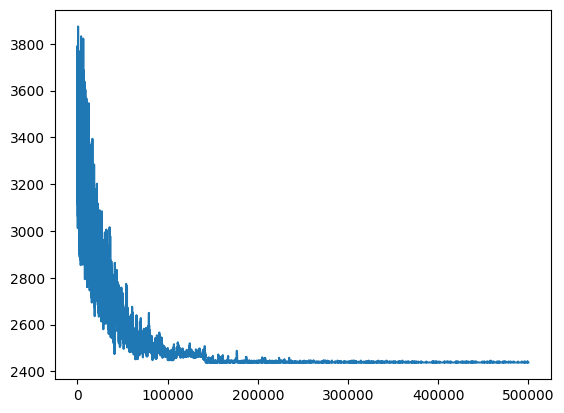

In [28]:
QAP_INSTANCE_URL = 'https://qaplib.mgi.polymtl.ca/data.d/nug21.dat'
n, A, B = read_instance(QAP_INSTANCE_URL)

T = 500000
radius = 1
alpha = 0.75

costs = simulated_annealing(T, radius, alpha, n, A, B)

plt.figure()
plt.plot(costs)
plt.show()

Problem size: 27
Flow matrix:
 [[ 0.  3.  2.  0.  0.  2. 10.  5.  0.  5.  2.  5.  0.  0.  2.  0.  5.  6.
   3.  0.  1. 10.  0. 10.  2.  1.  1.]
 [ 3.  0.  4.  0. 10.  4.  0.  0.  2.  2.  1.  0.  5.  0.  0.  0.  0.  2.
   0.  1.  6.  1.  0.  1.  2.  2.  5.]
 [ 2.  4.  0.  3.  4.  0.  5.  5.  5.  1.  4.  1.  0.  4.  0.  4.  0.  6.
   3.  2.  5.  5.  2.  1.  0.  0.  3.]
 [ 0.  0.  3.  0.  0.  0.  0.  2.  2.  0.  6.  0.  2.  5.  2.  5.  1.  1.
   1.  1.  2.  2.  4.  0.  2.  0.  2.]
 [ 0. 10.  4.  0.  0.  5.  2.  0.  0.  0.  0.  2.  0.  0.  0.  0.  2.  1.
   0.  0.  2.  0.  5.  1.  0.  2.  1.]
 [ 2.  4.  0.  0.  5.  0.  1.  2.  2.  1.  4. 10. 10.  2.  5.  5.  0.  5.
   0.  0.  0. 10.  0.  0.  0.  4.  0.]
 [10.  0.  5.  0.  2.  1.  0. 10. 10.  5. 10. 10.  6.  0.  0. 10.  2.  1.
  10.  1.  5.  5.  2.  3.  5.  0.  2.]
 [ 5.  0.  5.  2.  0.  2. 10.  0.  1.  3.  5.  0.  0.  0.  2.  4.  5.  2.
  10.  6.  0.  5.  5.  2.  5.  0.  5.]
 [ 0.  2.  5.  2.  0.  2. 10.  1.  0. 10.  2.  1.  5.  2.  0.  3.

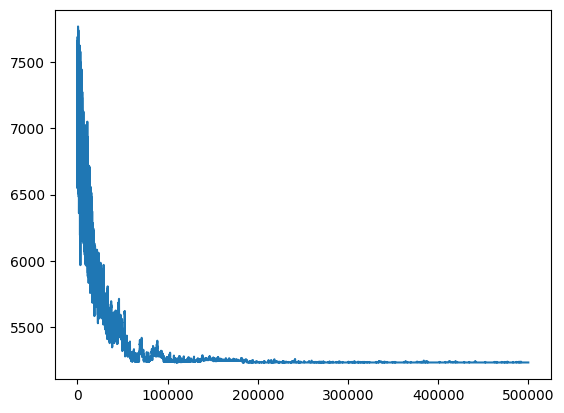

In [12]:
QAP_INSTANCE_URL = 'https://qaplib.mgi.polymtl.ca/data.d/nug27.dat'
n, A, B = read_instance(QAP_INSTANCE_URL)

T = 500000
radius = 1
alpha = 0.8

costs = simulated_annealing(T, radius, alpha, n, A, B)

plt.figure()
plt.plot(costs)
plt.show()

Problem size: 12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  

  0%|                                         | 1/500 [00:20<2:47:30, 20.14s/it]

20.14004945755005 578.0


  0%|▏                                        | 2/500 [00:40<2:46:54, 20.11s/it]

20.086469173431396 578.0


  1%|▏                                        | 3/500 [01:01<2:49:06, 20.42s/it]

20.780317306518555 578.0


  1%|▎                                        | 4/500 [01:21<2:48:50, 20.43s/it]

20.438825368881226 578.0


  1%|▍                                        | 5/500 [01:41<2:48:28, 20.42s/it]

20.41200089454651 578.0


  1%|▍                                        | 6/500 [02:01<2:46:43, 20.25s/it]

19.91706895828247 578.0


  1%|▌                                        | 7/500 [02:21<2:45:06, 20.09s/it]

19.77109408378601 578.0


  2%|▋                                        | 8/500 [02:41<2:44:10, 20.02s/it]

19.867902517318726 578.0


  2%|▋                                        | 9/500 [03:01<2:44:03, 20.05s/it]

20.10511302947998 578.0


  2%|▊                                       | 10/500 [03:21<2:44:38, 20.16s/it]

20.41091775894165 578.0


  2%|▉                                       | 11/500 [03:42<2:45:17, 20.28s/it]

20.55608344078064 578.0


  2%|▉                                       | 12/500 [04:02<2:44:12, 20.19s/it]

19.976412773132324 578.0


  3%|█                                       | 13/500 [04:22<2:43:10, 20.10s/it]

19.904551029205322 578.0


  3%|█                                       | 14/500 [04:42<2:42:26, 20.06s/it]

19.94457721710205 578.0


  3%|█▏                                      | 15/500 [05:02<2:41:30, 19.98s/it]

19.803870916366577 578.0


  3%|█▎                                      | 16/500 [05:21<2:40:50, 19.94s/it]

19.844115018844604 578.0


  3%|█▎                                      | 17/500 [05:41<2:40:23, 19.92s/it]

19.890408039093018 578.0


  4%|█▍                                      | 18/500 [06:01<2:40:01, 19.92s/it]

19.911918878555298 578.0


  4%|█▌                                      | 19/500 [06:21<2:39:32, 19.90s/it]

19.85670781135559 578.0


  4%|█▌                                      | 20/500 [06:41<2:38:49, 19.85s/it]

19.738504648208618 578.0


  4%|█▋                                      | 21/500 [07:01<2:38:19, 19.83s/it]

19.77944564819336 578.0


  4%|█▊                                      | 22/500 [07:20<2:37:55, 19.82s/it]

19.80504608154297 578.0


  5%|█▊                                      | 23/500 [07:40<2:37:35, 19.82s/it]

19.822514295578003 578.0


  5%|█▉                                      | 24/500 [08:00<2:37:10, 19.81s/it]

19.78236675262451 578.0


  5%|██                                      | 25/500 [08:20<2:37:18, 19.87s/it]

20.008862495422363 578.0


  5%|██                                      | 26/500 [08:40<2:36:40, 19.83s/it]

19.74406099319458 578.0


  5%|██▏                                     | 27/500 [09:00<2:36:19, 19.83s/it]

19.82452392578125 578.0


  6%|██▏                                     | 28/500 [09:20<2:37:30, 20.02s/it]

20.467930793762207 578.0


  6%|██▎                                     | 29/500 [09:40<2:37:00, 20.00s/it]

19.9497811794281 578.0


  6%|██▍                                     | 30/500 [10:00<2:36:10, 19.94s/it]

19.787858963012695 578.0


  6%|██▍                                     | 31/500 [10:20<2:35:34, 19.90s/it]

19.82115364074707 578.0


  6%|██▌                                     | 32/500 [10:40<2:35:39, 19.96s/it]

20.078999996185303 578.0


  7%|██▋                                     | 33/500 [11:00<2:35:03, 19.92s/it]

19.841964721679688 578.0


  7%|██▋                                     | 34/500 [11:19<2:34:26, 19.88s/it]

19.796836853027344 578.0


  7%|██▊                                     | 35/500 [11:39<2:33:54, 19.86s/it]

19.80094265937805 578.0


  7%|██▉                                     | 36/500 [12:00<2:34:44, 20.01s/it]

20.357377529144287 578.0


  7%|██▉                                     | 37/500 [12:20<2:34:16, 19.99s/it]

19.949548482894897 578.0


  8%|███                                     | 38/500 [12:40<2:34:44, 20.10s/it]

20.34217405319214 578.0


  8%|███                                     | 39/500 [13:00<2:33:37, 19.99s/it]

19.754638195037842 578.0


  8%|███▏                                    | 40/500 [13:19<2:32:55, 19.95s/it]

19.83641529083252 578.0


  8%|███▎                                    | 41/500 [13:39<2:32:07, 19.89s/it]

19.74140501022339 578.0


  8%|███▎                                    | 42/500 [13:59<2:31:34, 19.86s/it]

19.79232692718506 578.0


  9%|███▍                                    | 43/500 [14:19<2:31:11, 19.85s/it]

19.830708742141724 578.0


  9%|███▌                                    | 44/500 [14:39<2:30:42, 19.83s/it]

19.78186345100403 578.0


  9%|███▌                                    | 45/500 [14:58<2:30:18, 19.82s/it]

19.79782271385193 578.0


  9%|███▋                                    | 46/500 [15:18<2:29:53, 19.81s/it]

19.782262325286865 578.0


  9%|███▊                                    | 47/500 [15:38<2:29:51, 19.85s/it]

19.93868613243103 578.0


 10%|███▊                                    | 48/500 [15:58<2:29:33, 19.85s/it]

19.864811897277832 578.0


 10%|███▉                                    | 49/500 [16:18<2:29:08, 19.84s/it]

19.814207553863525 578.0


 10%|████                                    | 50/500 [16:38<2:28:38, 19.82s/it]

19.763924837112427 578.0


 10%|████                                    | 51/500 [16:57<2:28:16, 19.81s/it]

19.802026510238647 578.0


 10%|████▏                                   | 52/500 [17:17<2:28:32, 19.89s/it]

20.079829931259155 578.0


 11%|████▏                                   | 53/500 [17:37<2:28:13, 19.90s/it]

19.89965796470642 578.0


 11%|████▎                                   | 54/500 [17:57<2:27:30, 19.84s/it]

19.722949981689453 578.0


 11%|████▍                                   | 55/500 [18:17<2:27:23, 19.87s/it]

19.94090175628662 578.0


 11%|████▍                                   | 56/500 [18:37<2:26:53, 19.85s/it]

19.79524517059326 578.0


 11%|████▌                                   | 57/500 [18:57<2:26:20, 19.82s/it]

19.753014087677002 578.0


 12%|████▋                                   | 58/500 [19:16<2:25:56, 19.81s/it]

19.786105155944824 578.0


 12%|████▋                                   | 59/500 [19:36<2:25:46, 19.83s/it]

19.88427233695984 578.0


 12%|████▊                                   | 60/500 [19:56<2:25:09, 19.80s/it]

19.70542597770691 578.0


 12%|████▉                                   | 61/500 [20:16<2:24:45, 19.79s/it]

19.76248264312744 578.0


 12%|████▉                                   | 62/500 [20:36<2:24:48, 19.84s/it]

19.9528648853302 578.0


 13%|█████                                   | 63/500 [20:55<2:24:21, 19.82s/it]

19.780292987823486 578.0


 13%|█████                                   | 64/500 [21:15<2:24:06, 19.83s/it]

19.857917308807373 578.0


 13%|█████▏                                  | 65/500 [21:35<2:23:43, 19.82s/it]

19.807061195373535 578.0


 13%|█████▎                                  | 66/500 [21:55<2:23:10, 19.79s/it]

19.722203016281128 578.0


 13%|█████▎                                  | 67/500 [22:15<2:22:54, 19.80s/it]

19.823208570480347 578.0


 14%|█████▍                                  | 68/500 [22:34<2:22:38, 19.81s/it]

19.831929683685303 578.0


 14%|█████▌                                  | 69/500 [22:54<2:22:33, 19.85s/it]

19.92339324951172 578.0


 14%|█████▌                                  | 70/500 [23:14<2:22:17, 19.86s/it]

19.877819776535034 578.0


 14%|█████▋                                  | 71/500 [23:34<2:21:50, 19.84s/it]

19.79576587677002 578.0


 14%|█████▊                                  | 72/500 [23:54<2:21:41, 19.86s/it]

19.920400857925415 578.0


 15%|█████▊                                  | 73/500 [24:14<2:21:20, 19.86s/it]

19.857704162597656 578.0


 15%|█████▉                                  | 74/500 [24:34<2:21:17, 19.90s/it]

19.9887752532959 578.0


 15%|██████                                  | 75/500 [24:54<2:20:51, 19.88s/it]

19.848740339279175 578.0


 15%|██████                                  | 76/500 [25:14<2:20:27, 19.88s/it]

19.85764718055725 578.0


 15%|██████▏                                 | 77/500 [25:33<2:19:59, 19.86s/it]

19.812499284744263 578.0


 16%|██████▏                                 | 78/500 [25:53<2:19:29, 19.83s/it]

19.777279138565063 578.0


 16%|██████▎                                 | 79/500 [26:13<2:19:05, 19.82s/it]

19.793575048446655 578.0


 16%|██████▍                                 | 80/500 [26:33<2:18:43, 19.82s/it]

19.805068969726562 578.0


 16%|██████▍                                 | 81/500 [26:53<2:18:36, 19.85s/it]

19.919456243515015 578.0


 16%|██████▌                                 | 82/500 [27:12<2:18:07, 19.83s/it]

19.771910667419434 578.0


 17%|██████▋                                 | 83/500 [27:32<2:17:47, 19.83s/it]

19.82408380508423 578.0


 17%|██████▋                                 | 84/500 [27:52<2:17:34, 19.84s/it]

19.879138708114624 578.0


 17%|██████▊                                 | 85/500 [28:12<2:17:16, 19.85s/it]

19.86001205444336 582.0


 17%|██████▉                                 | 86/500 [28:32<2:16:59, 19.85s/it]

19.868531703948975 578.0


 17%|██████▉                                 | 87/500 [28:52<2:16:53, 19.89s/it]

19.964314937591553 578.0


 18%|███████                                 | 88/500 [29:12<2:16:42, 19.91s/it]

19.95581364631653 578.0


 18%|███████                                 | 89/500 [29:32<2:16:14, 19.89s/it]

19.844887733459473 578.0


 18%|███████▏                                | 90/500 [29:51<2:15:42, 19.86s/it]

19.793217658996582 582.0


 18%|███████▎                                | 91/500 [30:11<2:15:16, 19.84s/it]

19.802597522735596 578.0


 18%|███████▎                                | 92/500 [30:31<2:14:51, 19.83s/it]

19.801365852355957 578.0


 19%|███████▍                                | 93/500 [30:51<2:14:42, 19.86s/it]

19.922624826431274 578.0


 19%|███████▌                                | 94/500 [31:11<2:14:27, 19.87s/it]

19.89353036880493 578.0


 19%|███████▌                                | 95/500 [31:31<2:14:07, 19.87s/it]

19.871634483337402 578.0


 19%|███████▋                                | 96/500 [31:51<2:13:50, 19.88s/it]

19.88937020301819 578.0


 19%|███████▊                                | 97/500 [32:10<2:13:27, 19.87s/it]

19.85554075241089 578.0


 20%|███████▊                                | 98/500 [32:31<2:13:29, 19.92s/it]

20.050472259521484 578.0


 20%|███████▉                                | 99/500 [32:50<2:13:11, 19.93s/it]

19.942396640777588 578.0


 20%|███████▊                               | 100/500 [33:10<2:12:38, 19.90s/it]

19.81453561782837 578.0


 20%|███████▉                               | 101/500 [33:30<2:12:12, 19.88s/it]

19.842974185943604 578.0


 20%|███████▉                               | 102/500 [33:50<2:11:50, 19.88s/it]

19.86806631088257 578.0


 21%|████████                               | 103/500 [34:10<2:11:33, 19.88s/it]

19.899559020996094 578.0


 21%|████████                               | 104/500 [34:30<2:11:07, 19.87s/it]

19.829331398010254 578.0


 21%|████████▏                              | 105/500 [34:50<2:10:41, 19.85s/it]

19.814946174621582 578.0


 21%|████████▎                              | 106/500 [35:09<2:10:12, 19.83s/it]

19.776378393173218 578.0


 21%|████████▎                              | 107/500 [35:29<2:09:51, 19.83s/it]

19.81577968597412 578.0


 22%|████████▍                              | 108/500 [35:49<2:09:26, 19.81s/it]

19.78316640853882 578.0


 22%|████████▌                              | 109/500 [36:09<2:09:28, 19.87s/it]

19.992324590682983 578.0


 22%|████████▌                              | 110/500 [36:29<2:09:14, 19.88s/it]

19.917996168136597 578.0


 22%|████████▋                              | 111/500 [36:49<2:08:48, 19.87s/it]

19.831223964691162 578.0


 22%|████████▋                              | 112/500 [37:09<2:08:35, 19.88s/it]

19.925107955932617 578.0


 23%|████████▊                              | 113/500 [37:28<2:08:11, 19.87s/it]

19.848401069641113 578.0


 23%|████████▉                              | 114/500 [37:48<2:07:47, 19.86s/it]

19.83548927307129 578.0


 23%|████████▉                              | 115/500 [38:08<2:07:22, 19.85s/it]

19.818527460098267 578.0


 23%|█████████                              | 116/500 [38:28<2:06:47, 19.81s/it]

19.72252583503723 578.0


 23%|█████████▏                             | 117/500 [38:48<2:06:25, 19.80s/it]

19.786007404327393 578.0


 24%|█████████▏                             | 118/500 [39:07<2:06:03, 19.80s/it]

19.79017996788025 578.0


 24%|█████████▎                             | 119/500 [39:27<2:05:33, 19.77s/it]

19.708285808563232 578.0


 24%|█████████▎                             | 120/500 [39:47<2:05:12, 19.77s/it]

19.764941215515137 578.0


 24%|█████████▍                             | 121/500 [40:07<2:05:11, 19.82s/it]

19.93201231956482 578.0


 24%|█████████▌                             | 122/500 [40:27<2:04:57, 19.83s/it]

19.868014574050903 578.0


 25%|█████████▌                             | 123/500 [40:47<2:04:42, 19.85s/it]

19.87725281715393 578.0


 25%|█████████▋                             | 124/500 [41:06<2:04:14, 19.83s/it]

19.777668714523315 578.0


 25%|█████████▊                             | 125/500 [41:26<2:03:48, 19.81s/it]

19.771305322647095 582.0


 25%|█████████▊                             | 126/500 [41:46<2:03:29, 19.81s/it]

19.815727472305298 578.0


 25%|█████████▉                             | 127/500 [42:06<2:03:12, 19.82s/it]

19.83165740966797 578.0


 26%|█████████▉                             | 128/500 [42:26<2:02:55, 19.83s/it]

19.84396195411682 578.0


 26%|██████████                             | 129/500 [42:45<2:02:38, 19.83s/it]

19.85347557067871 578.0


 26%|██████████▏                            | 130/500 [43:05<2:02:18, 19.83s/it]

19.83334970474243 578.0


 26%|██████████▏                            | 131/500 [43:25<2:02:10, 19.87s/it]

19.93662142753601 578.0


 26%|██████████▎                            | 132/500 [43:45<2:01:44, 19.85s/it]

19.806620359420776 578.0


 27%|██████████▎                            | 133/500 [44:05<2:01:31, 19.87s/it]

19.911954402923584 578.0


 27%|██████████▍                            | 134/500 [44:25<2:01:10, 19.87s/it]

19.859689712524414 582.0


 27%|██████████▌                            | 135/500 [44:45<2:00:40, 19.84s/it]

19.766891956329346 578.0


 27%|██████████▌                            | 136/500 [45:04<2:00:16, 19.83s/it]

19.803607940673828 578.0


 27%|██████████▋                            | 137/500 [45:24<1:59:54, 19.82s/it]

19.804410934448242 578.0


 28%|██████████▊                            | 138/500 [45:44<1:59:30, 19.81s/it]

19.783051252365112 578.0


 28%|██████████▊                            | 139/500 [46:04<1:59:22, 19.84s/it]

19.917816162109375 578.0


 28%|██████████▉                            | 140/500 [46:24<1:58:52, 19.81s/it]

19.74641180038452 578.0


 28%|██████████▉                            | 141/500 [46:44<1:58:46, 19.85s/it]

19.93444323539734 578.0


 28%|███████████                            | 142/500 [47:03<1:58:34, 19.87s/it]

19.922746658325195 578.0


 29%|███████████▏                           | 143/500 [47:23<1:58:09, 19.86s/it]

19.828972339630127 578.0


 29%|███████████▏                           | 144/500 [47:43<1:57:48, 19.85s/it]

19.84148597717285 578.0


 29%|███████████▎                           | 145/500 [48:03<1:57:08, 19.80s/it]

19.666538953781128 578.0


 29%|███████████▍                           | 146/500 [48:23<1:57:11, 19.86s/it]

20.011191606521606 586.0


 29%|███████████▍                           | 147/500 [48:43<1:56:58, 19.88s/it]

19.929675579071045 578.0


 30%|███████████▌                           | 148/500 [49:03<1:56:39, 19.88s/it]

19.888073205947876 578.0


 30%|███████████▌                           | 149/500 [49:22<1:56:01, 19.83s/it]

19.713067531585693 578.0


 30%|███████████▋                           | 150/500 [49:42<1:55:45, 19.84s/it]

19.86456847190857 578.0


 30%|███████████▊                           | 151/500 [50:02<1:55:24, 19.84s/it]

19.838258981704712 578.0


 30%|███████████▊                           | 152/500 [50:22<1:55:03, 19.84s/it]

19.828198194503784 578.0


 31%|███████████▉                           | 153/500 [50:42<1:54:38, 19.82s/it]

19.7891743183136 578.0


 31%|████████████                           | 154/500 [51:01<1:54:14, 19.81s/it]

19.778552532196045 578.0


 31%|████████████                           | 155/500 [51:21<1:53:51, 19.80s/it]

19.783637046813965 578.0


 31%|████████████▏                          | 156/500 [51:41<1:53:31, 19.80s/it]

19.79324746131897 578.0


 31%|████████████▏                          | 157/500 [52:01<1:53:09, 19.80s/it]

19.78452229499817 578.0


 32%|████████████▎                          | 158/500 [52:21<1:52:52, 19.80s/it]

19.82240867614746 578.0


 32%|████████████▍                          | 159/500 [52:41<1:52:43, 19.83s/it]

19.90496253967285 578.0


 32%|████████████▍                          | 160/500 [53:00<1:52:21, 19.83s/it]

19.816837072372437 586.0


 32%|████████████▌                          | 161/500 [53:20<1:51:59, 19.82s/it]

19.80395531654358 578.0


 32%|████████████▋                          | 162/500 [53:40<1:51:48, 19.85s/it]

19.9061336517334 578.0


 33%|████████████▋                          | 163/500 [54:00<1:51:42, 19.89s/it]

19.9801344871521 578.0


 33%|████████████▊                          | 164/500 [54:20<1:51:29, 19.91s/it]

19.962263107299805 578.0


 33%|████████████▊                          | 165/500 [54:40<1:51:02, 19.89s/it]

19.839465618133545 578.0


 33%|████████████▉                          | 166/500 [55:00<1:50:55, 19.93s/it]

20.015015840530396 578.0


 33%|█████████████                          | 167/500 [55:20<1:50:13, 19.86s/it]

19.707532167434692 578.0


 34%|█████████████                          | 168/500 [55:39<1:49:50, 19.85s/it]

19.827200412750244 582.0


 34%|█████████████▏                         | 169/500 [55:59<1:49:52, 19.92s/it]

20.065675258636475 578.0


 34%|█████████████▎                         | 170/500 [56:19<1:49:17, 19.87s/it]

19.761640787124634 578.0


 34%|█████████████▎                         | 171/500 [56:39<1:48:49, 19.85s/it]

19.786254405975342 578.0


 34%|█████████████▍                         | 172/500 [56:59<1:48:28, 19.84s/it]

19.832970142364502 578.0


 35%|█████████████▍                         | 173/500 [57:19<1:48:02, 19.82s/it]

19.778234481811523 578.0


 35%|█████████████▌                         | 174/500 [57:39<1:47:48, 19.84s/it]

19.890677452087402 578.0


 35%|█████████████▋                         | 175/500 [57:58<1:47:24, 19.83s/it]

19.791350841522217 578.0


 35%|█████████████▋                         | 176/500 [58:18<1:47:01, 19.82s/it]

19.79431939125061 578.0


 35%|█████████████▊                         | 177/500 [58:38<1:46:42, 19.82s/it]

19.83066201210022 578.0


 36%|█████████████▉                         | 178/500 [58:58<1:46:21, 19.82s/it]

19.809383153915405 578.0


 36%|█████████████▉                         | 179/500 [59:18<1:46:11, 19.85s/it]

19.917349576950073 578.0


 36%|██████████████                         | 180/500 [59:38<1:45:53, 19.85s/it]

19.864680290222168 578.0


 36%|██████████████                         | 181/500 [59:57<1:45:35, 19.86s/it]

19.87228226661682 578.0


 36%|█████████████▍                       | 182/500 [1:00:17<1:45:01, 19.82s/it]

19.71536350250244 578.0


 37%|█████████████▌                       | 183/500 [1:00:37<1:44:46, 19.83s/it]

19.8645339012146 578.0


 37%|█████████████▌                       | 184/500 [1:00:57<1:44:32, 19.85s/it]

19.894233226776123 578.0


 37%|█████████████▋                       | 185/500 [1:01:17<1:44:13, 19.85s/it]

19.859915018081665 578.0


 37%|█████████████▊                       | 186/500 [1:01:37<1:43:44, 19.82s/it]

19.75380516052246 578.0


 37%|█████████████▊                       | 187/500 [1:01:56<1:43:20, 19.81s/it]

19.77962303161621 578.0


 38%|█████████████▉                       | 188/500 [1:02:16<1:43:01, 19.81s/it]

19.811663150787354 578.0


 38%|█████████████▉                       | 189/500 [1:02:36<1:42:45, 19.82s/it]

19.854655504226685 578.0


 38%|██████████████                       | 190/500 [1:02:56<1:42:31, 19.84s/it]

19.885771989822388 578.0


 38%|██████████████▏                      | 191/500 [1:03:16<1:42:09, 19.84s/it]

19.82028079032898 578.0


 38%|██████████████▏                      | 192/500 [1:03:36<1:41:50, 19.84s/it]

19.841695070266724 578.0


 39%|██████████████▎                      | 193/500 [1:03:55<1:41:26, 19.83s/it]

19.794676303863525 578.0


 39%|██████████████▎                      | 194/500 [1:04:15<1:41:28, 19.90s/it]

20.067832946777344 578.0


 39%|██████████████▍                      | 195/500 [1:04:35<1:41:02, 19.88s/it]

19.821390867233276 578.0


 39%|██████████████▌                      | 196/500 [1:04:55<1:40:46, 19.89s/it]

19.92613959312439 578.0


 39%|██████████████▌                      | 197/500 [1:05:16<1:41:40, 20.13s/it]

20.700196027755737 578.0


 40%|██████████████▋                      | 198/500 [1:05:37<1:42:18, 20.33s/it]

20.770426034927368 578.0


 40%|██████████████▋                      | 199/500 [1:05:59<1:44:30, 20.83s/it]

22.009203910827637 578.0


 40%|██████████████▊                      | 200/500 [1:06:19<1:43:09, 20.63s/it]

20.157544374465942 578.0


 40%|██████████████▊                      | 201/500 [1:06:39<1:41:38, 20.40s/it]

19.851749897003174 578.0


 40%|██████████████▉                      | 202/500 [1:06:59<1:40:41, 20.27s/it]

19.986482620239258 578.0


 41%|███████████████                      | 203/500 [1:07:19<1:40:29, 20.30s/it]

20.367704391479492 578.0


 41%|███████████████                      | 204/500 [1:07:39<1:39:21, 20.14s/it]

19.762882232666016 578.0


 41%|███████████████▏                     | 205/500 [1:07:59<1:38:39, 20.07s/it]

19.89205527305603 578.0


 41%|███████████████▏                     | 206/500 [1:08:18<1:37:59, 20.00s/it]

19.83393406867981 578.0


 41%|███████████████▎                     | 207/500 [1:08:38<1:37:22, 19.94s/it]

19.80425000190735 578.0


 42%|███████████████▍                     | 208/500 [1:08:59<1:37:36, 20.06s/it]

20.326268672943115 578.0


 42%|███████████████▍                     | 209/500 [1:09:18<1:37:00, 20.00s/it]

19.874502658843994 578.0


 42%|███████████████▌                     | 210/500 [1:09:39<1:36:57, 20.06s/it]

20.193265438079834 578.0


 42%|███████████████▌                     | 211/500 [1:09:59<1:37:07, 20.16s/it]

20.4078369140625 578.0


 42%|███████████████▋                     | 212/500 [1:10:19<1:36:20, 20.07s/it]

19.856297254562378 578.0


 43%|███████████████▊                     | 213/500 [1:10:39<1:35:40, 20.00s/it]

19.83962059020996 578.0


 43%|███████████████▊                     | 214/500 [1:10:59<1:36:02, 20.15s/it]

20.48992347717285 578.0


 43%|███████████████▉                     | 215/500 [1:11:19<1:35:08, 20.03s/it]

19.755648851394653 578.0


 43%|███████████████▉                     | 216/500 [1:11:39<1:34:32, 19.97s/it]

19.839336395263672 578.0


 43%|████████████████                     | 217/500 [1:11:59<1:34:02, 19.94s/it]

19.85129427909851 578.0


 44%|████████████████▏                    | 218/500 [1:12:19<1:33:42, 19.94s/it]

19.934056520462036 578.0


 44%|████████████████▏                    | 219/500 [1:12:39<1:33:15, 19.91s/it]

19.859158754348755 578.0


 44%|████████████████▎                    | 220/500 [1:12:58<1:32:50, 19.89s/it]

19.845260858535767 578.0


 44%|████████████████▎                    | 221/500 [1:13:18<1:32:29, 19.89s/it]

19.888087511062622 578.0


 44%|████████████████▍                    | 222/500 [1:13:38<1:32:21, 19.93s/it]

20.02418041229248 578.0


 45%|████████████████▌                    | 223/500 [1:13:58<1:31:59, 19.93s/it]

19.91232943534851 578.0


 45%|████████████████▌                    | 224/500 [1:14:18<1:31:30, 19.89s/it]

19.820362091064453 578.0


 45%|████████████████▋                    | 225/500 [1:14:38<1:31:13, 19.90s/it]

19.920121908187866 578.0


 45%|████████████████▋                    | 226/500 [1:14:58<1:30:40, 19.86s/it]

19.748407125473022 578.0


 45%|████████████████▊                    | 227/500 [1:15:17<1:30:16, 19.84s/it]

19.80152153968811 586.0


 46%|████████████████▊                    | 228/500 [1:15:37<1:30:00, 19.86s/it]

19.890124559402466 578.0


 46%|████████████████▉                    | 229/500 [1:15:57<1:29:38, 19.85s/it]

19.82958436012268 578.0


 46%|█████████████████                    | 230/500 [1:16:17<1:29:50, 19.97s/it]

20.242467164993286 578.0


 46%|█████████████████                    | 231/500 [1:16:37<1:29:26, 19.95s/it]

19.91339874267578 578.0


 46%|█████████████████▏                   | 232/500 [1:16:58<1:29:41, 20.08s/it]

20.384971380233765 578.0


 47%|█████████████████▏                   | 233/500 [1:17:18<1:29:34, 20.13s/it]

20.242839336395264 578.0


 47%|█████████████████▎                   | 234/500 [1:17:38<1:29:10, 20.12s/it]

20.080049753189087 578.0


 47%|█████████████████▍                   | 235/500 [1:17:58<1:28:35, 20.06s/it]

19.92600679397583 578.0


 47%|█████████████████▍                   | 236/500 [1:18:18<1:27:54, 19.98s/it]

19.798237562179565 578.0


 47%|█████████████████▌                   | 237/500 [1:18:38<1:28:14, 20.13s/it]

20.48442053794861 578.0


 48%|█████████████████▌                   | 238/500 [1:18:58<1:27:51, 20.12s/it]

20.08610701560974 578.0


 48%|█████████████████▋                   | 239/500 [1:19:18<1:27:24, 20.09s/it]

20.035884857177734 578.0


 48%|█████████████████▊                   | 240/500 [1:19:38<1:26:41, 20.01s/it]

19.797882318496704 578.0


 48%|█████████████████▊                   | 241/500 [1:19:58<1:26:08, 19.96s/it]

19.842398166656494 578.0


 48%|█████████████████▉                   | 242/500 [1:20:19<1:26:58, 20.23s/it]

20.86017942428589 578.0


 49%|█████████████████▉                   | 243/500 [1:20:39<1:27:01, 20.32s/it]

20.52845859527588 578.0


 49%|██████████████████                   | 244/500 [1:20:59<1:26:04, 20.17s/it]

19.83709406852722 578.0


 49%|██████████████████▏                  | 245/500 [1:21:19<1:25:26, 20.11s/it]

19.94282603263855 578.0


 49%|██████████████████▏                  | 246/500 [1:21:40<1:25:29, 20.19s/it]

20.400044202804565 578.0


 49%|██████████████████▎                  | 247/500 [1:21:59<1:24:41, 20.09s/it]

19.830990076065063 578.0


 50%|██████████████████▎                  | 248/500 [1:22:19<1:23:59, 20.00s/it]

19.79053020477295 578.0


 50%|██████████████████▍                  | 249/500 [1:22:39<1:23:26, 19.95s/it]

19.831656217575073 578.0


 50%|██████████████████▌                  | 250/500 [1:22:59<1:23:01, 19.93s/it]

19.874797105789185 578.0


 50%|██████████████████▌                  | 251/500 [1:23:19<1:22:31, 19.89s/it]

19.79093027114868 578.0


 50%|██████████████████▋                  | 252/500 [1:23:39<1:22:18, 19.91s/it]

19.977628469467163 578.0


 51%|██████████████████▋                  | 253/500 [1:23:59<1:21:50, 19.88s/it]

19.79763412475586 578.0


 51%|██████████████████▊                  | 254/500 [1:24:18<1:21:27, 19.87s/it]

19.83646273612976 578.0


 51%|██████████████████▊                  | 255/500 [1:24:38<1:20:58, 19.83s/it]

19.744842290878296 578.0


 51%|██████████████████▉                  | 256/500 [1:24:58<1:20:41, 19.84s/it]

19.867085695266724 578.0


 51%|███████████████████                  | 257/500 [1:25:18<1:20:17, 19.83s/it]

19.78623390197754 578.0


 52%|███████████████████                  | 258/500 [1:25:38<1:19:56, 19.82s/it]

19.811873197555542 578.0


 52%|███████████████████▏                 | 259/500 [1:25:57<1:19:39, 19.83s/it]

19.85769820213318 578.0


 52%|███████████████████▏                 | 260/500 [1:26:17<1:19:18, 19.83s/it]

19.815104484558105 578.0


 52%|███████████████████▎                 | 261/500 [1:26:37<1:19:05, 19.86s/it]

19.925144910812378 578.0


 52%|███████████████████▍                 | 262/500 [1:26:57<1:18:41, 19.84s/it]

19.78735065460205 578.0


 53%|███████████████████▍                 | 263/500 [1:27:17<1:18:13, 19.80s/it]

19.730640649795532 578.0


 53%|███████████████████▌                 | 264/500 [1:27:37<1:17:55, 19.81s/it]

19.830358028411865 578.0


 53%|███████████████████▌                 | 265/500 [1:27:57<1:17:48, 19.87s/it]

19.99140214920044 578.0


 53%|███████████████████▋                 | 266/500 [1:28:16<1:17:25, 19.85s/it]

19.819558143615723 578.0


 53%|███████████████████▊                 | 267/500 [1:28:36<1:17:07, 19.86s/it]

19.87313675880432 578.0


 54%|███████████████████▊                 | 268/500 [1:28:56<1:16:45, 19.85s/it]

19.837817907333374 578.0


 54%|███████████████████▉                 | 269/500 [1:29:16<1:16:29, 19.87s/it]

19.896936893463135 578.0


 54%|███████████████████▉                 | 270/500 [1:29:36<1:16:01, 19.83s/it]

19.750089406967163 578.0


 54%|████████████████████                 | 271/500 [1:29:56<1:15:38, 19.82s/it]

19.793657779693604 578.0


 54%|████████████████████▏                | 272/500 [1:30:15<1:15:09, 19.78s/it]

19.683406591415405 578.0


 55%|████████████████████▏                | 273/500 [1:30:35<1:14:57, 19.81s/it]

19.888075351715088 578.0


 55%|████████████████████▎                | 274/500 [1:30:55<1:14:34, 19.80s/it]

19.762389659881592 578.0


 55%|████████████████████▎                | 275/500 [1:31:14<1:14:03, 19.75s/it]

19.63420271873474 578.0


 55%|████████████████████▍                | 276/500 [1:31:34<1:13:49, 19.77s/it]

19.83165669441223 578.0


 55%|████████████████████▍                | 277/500 [1:31:54<1:13:23, 19.75s/it]

19.681952953338623 578.0


 56%|████████████████████▌                | 278/500 [1:32:14<1:13:04, 19.75s/it]

19.750425100326538 578.0


 56%|████████████████████▋                | 279/500 [1:32:33<1:12:38, 19.72s/it]

19.662402391433716 578.0


 56%|████████████████████▋                | 280/500 [1:32:53<1:12:22, 19.74s/it]

19.77207636833191 578.0


 56%|████████████████████▊                | 281/500 [1:33:13<1:12:04, 19.74s/it]

19.760013580322266 578.0


 56%|████████████████████▊                | 282/500 [1:33:33<1:11:47, 19.76s/it]

19.790372133255005 578.0


 57%|████████████████████▉                | 283/500 [1:33:53<1:11:34, 19.79s/it]

19.86681818962097 578.0


 57%|█████████████████████                | 284/500 [1:34:12<1:11:22, 19.82s/it]

19.901379823684692 578.0


 57%|█████████████████████                | 285/500 [1:34:32<1:11:11, 19.87s/it]

19.9633047580719 578.0


 57%|█████████████████████▏               | 286/500 [1:34:52<1:10:51, 19.87s/it]

19.873342752456665 578.0


 57%|█████████████████████▏               | 287/500 [1:35:12<1:10:33, 19.87s/it]

19.885949850082397 578.0


 58%|█████████████████████▎               | 288/500 [1:35:32<1:10:23, 19.92s/it]

20.03265690803528 578.0


 58%|█████████████████████▍               | 289/500 [1:35:52<1:10:01, 19.91s/it]

19.882287740707397 578.0


 58%|█████████████████████▍               | 290/500 [1:36:12<1:09:31, 19.87s/it]

19.760868310928345 578.0


 58%|█████████████████████▌               | 291/500 [1:36:32<1:09:06, 19.84s/it]

19.77440071105957 578.0


 58%|█████████████████████▌               | 292/500 [1:36:51<1:08:44, 19.83s/it]

19.800628900527954 578.0


 59%|█████████████████████▋               | 293/500 [1:37:11<1:08:26, 19.84s/it]

19.857359886169434 578.0


 59%|█████████████████████▊               | 294/500 [1:37:31<1:08:04, 19.83s/it]

19.798553943634033 578.0


 59%|█████████████████████▊               | 295/500 [1:37:51<1:07:42, 19.82s/it]

19.80433464050293 578.0


 59%|█████████████████████▉               | 296/500 [1:38:11<1:07:25, 19.83s/it]

19.863074779510498 586.0


 59%|█████████████████████▉               | 297/500 [1:38:31<1:07:04, 19.82s/it]

19.802685976028442 578.0


 60%|██████████████████████               | 298/500 [1:38:50<1:06:42, 19.81s/it]

19.790635585784912 578.0


 60%|██████████████████████▏              | 299/500 [1:39:10<1:06:20, 19.80s/it]

19.771116018295288 578.0


 60%|██████████████████████▏              | 300/500 [1:39:30<1:06:03, 19.82s/it]

19.850530862808228 578.0


 60%|██████████████████████▎              | 301/500 [1:39:50<1:05:45, 19.83s/it]

19.852123498916626 578.0


 60%|██████████████████████▎              | 302/500 [1:40:10<1:05:24, 19.82s/it]

19.803813934326172 578.0


 61%|██████████████████████▍              | 303/500 [1:40:30<1:05:09, 19.84s/it]

19.898192882537842 578.0


 61%|██████████████████████▍              | 304/500 [1:40:49<1:04:47, 19.83s/it]

19.806243896484375 578.0


 61%|██████████████████████▌              | 305/500 [1:41:09<1:04:27, 19.84s/it]

19.839316606521606 578.0


 61%|██████████████████████▋              | 306/500 [1:41:29<1:04:01, 19.80s/it]

19.730278730392456 578.0


 61%|██████████████████████▋              | 307/500 [1:41:49<1:03:40, 19.80s/it]

19.774125576019287 578.0


 62%|██████████████████████▊              | 308/500 [1:42:09<1:03:20, 19.79s/it]

19.792088270187378 578.0


 62%|██████████████████████▊              | 309/500 [1:42:28<1:03:04, 19.82s/it]

19.866587162017822 578.0


 62%|██████████████████████▉              | 310/500 [1:42:48<1:02:42, 19.80s/it]

19.771305561065674 578.0


 62%|███████████████████████              | 311/500 [1:43:08<1:02:23, 19.81s/it]

19.81972908973694 578.0


 62%|███████████████████████              | 312/500 [1:43:28<1:02:05, 19.81s/it]

19.827080249786377 578.0


 63%|███████████████████████▏             | 313/500 [1:43:48<1:01:45, 19.82s/it]

19.82634425163269 578.0


 63%|███████████████████████▏             | 314/500 [1:44:07<1:01:25, 19.82s/it]

19.813568830490112 578.0


 63%|███████████████████████▎             | 315/500 [1:44:27<1:01:06, 19.82s/it]

19.82496213912964 578.0


 63%|███████████████████████▍             | 316/500 [1:44:47<1:00:51, 19.84s/it]

19.896907329559326 578.0


 63%|███████████████████████▍             | 317/500 [1:45:07<1:00:30, 19.84s/it]

19.823879718780518 578.0


 64%|███████████████████████▌             | 318/500 [1:45:27<1:00:14, 19.86s/it]

19.90320348739624 578.0


 64%|████████████████████████▉              | 319/500 [1:45:47<59:51, 19.84s/it]

19.804122924804688 578.0


 64%|████████████████████████▉              | 320/500 [1:46:07<59:32, 19.84s/it]

19.85143780708313 578.0


 64%|█████████████████████████              | 321/500 [1:46:26<59:13, 19.85s/it]

19.862498998641968 578.0


 64%|█████████████████████████              | 322/500 [1:46:46<58:48, 19.82s/it]

19.7497341632843 578.0


 65%|█████████████████████████▏             | 323/500 [1:47:06<58:25, 19.80s/it]

19.76202893257141 578.0


 65%|█████████████████████████▎             | 324/500 [1:47:26<58:06, 19.81s/it]

19.821227312088013 578.0


 65%|█████████████████████████▎             | 325/500 [1:47:46<57:46, 19.81s/it]

19.809704542160034 578.0


 65%|█████████████████████████▍             | 326/500 [1:48:05<57:29, 19.82s/it]

19.854981184005737 578.0


 65%|█████████████████████████▌             | 327/500 [1:48:25<57:16, 19.86s/it]

19.955003261566162 578.0


 66%|█████████████████████████▌             | 328/500 [1:48:45<57:01, 19.89s/it]

19.956689596176147 578.0


 66%|█████████████████████████▋             | 329/500 [1:49:05<56:36, 19.86s/it]

19.800360918045044 578.0


 66%|█████████████████████████▋             | 330/500 [1:49:25<56:22, 19.90s/it]

19.97001004219055 578.0


 66%|█████████████████████████▊             | 331/500 [1:49:45<56:04, 19.91s/it]

19.932388305664062 578.0


 66%|█████████████████████████▉             | 332/500 [1:50:05<55:38, 19.87s/it]

19.79155969619751 578.0


 67%|█████████████████████████▉             | 333/500 [1:50:25<55:18, 19.87s/it]

19.86469030380249 578.0


 67%|██████████████████████████             | 334/500 [1:50:44<54:54, 19.84s/it]

19.779289960861206 578.0


 67%|██████████████████████████▏            | 335/500 [1:51:04<54:35, 19.85s/it]

19.876240730285645 578.0


 67%|██████████████████████████▏            | 336/500 [1:51:24<54:12, 19.83s/it]

19.77898645401001 578.0


 67%|██████████████████████████▎            | 337/500 [1:51:44<53:53, 19.84s/it]

19.85941481590271 578.0


 68%|██████████████████████████▎            | 338/500 [1:52:04<53:31, 19.82s/it]

19.788127422332764 578.0


 68%|██████████████████████████▍            | 339/500 [1:52:24<53:18, 19.87s/it]

19.971302270889282 578.0


 68%|██████████████████████████▌            | 340/500 [1:52:44<52:54, 19.84s/it]

19.783448219299316 578.0


 68%|██████████████████████████▌            | 341/500 [1:53:03<52:33, 19.83s/it]

19.801857709884644 578.0


 68%|██████████████████████████▋            | 342/500 [1:53:23<52:11, 19.82s/it]

19.796189546585083 578.0


 69%|██████████████████████████▊            | 343/500 [1:53:43<51:46, 19.78s/it]

19.696227073669434 578.0


 69%|██████████████████████████▊            | 344/500 [1:54:03<51:35, 19.84s/it]

19.984946250915527 578.0


 69%|██████████████████████████▉            | 345/500 [1:54:23<51:14, 19.83s/it]

19.8059663772583 578.0


 69%|██████████████████████████▉            | 346/500 [1:54:42<50:52, 19.82s/it]

19.785606861114502 578.0


 69%|███████████████████████████            | 347/500 [1:55:03<50:47, 19.92s/it]

20.148354053497314 578.0


 70%|███████████████████████████▏           | 348/500 [1:55:23<50:38, 19.99s/it]

20.15614938735962 578.0


 70%|███████████████████████████▏           | 349/500 [1:55:43<50:11, 19.94s/it]

19.8385329246521 578.0


 70%|███████████████████████████▎           | 350/500 [1:56:02<49:43, 19.89s/it]

19.76851749420166 578.0


 70%|███████████████████████████▍           | 351/500 [1:56:22<49:29, 19.93s/it]

20.01662826538086 578.0


 70%|███████████████████████████▍           | 352/500 [1:56:42<49:05, 19.90s/it]

19.829325199127197 578.0


 71%|███████████████████████████▌           | 353/500 [1:57:02<48:40, 19.87s/it]

19.791208267211914 578.0


 71%|███████████████████████████▌           | 354/500 [1:57:22<48:22, 19.88s/it]

19.91132664680481 578.0


 71%|███████████████████████████▋           | 355/500 [1:57:42<48:02, 19.88s/it]

19.87287139892578 578.0


 71%|███████████████████████████▊           | 356/500 [1:58:02<47:47, 19.92s/it]

19.999573230743408 578.0


 71%|███████████████████████████▊           | 357/500 [1:58:22<47:24, 19.89s/it]

19.841336727142334 578.0


 72%|███████████████████████████▉           | 358/500 [1:58:42<47:10, 19.94s/it]

20.03362488746643 578.0


 72%|████████████████████████████           | 359/500 [1:59:02<46:51, 19.94s/it]

19.939455032348633 578.0


 72%|████████████████████████████           | 360/500 [1:59:22<46:43, 20.03s/it]

20.23352026939392 578.0


 72%|████████████████████████████▏          | 361/500 [1:59:42<46:16, 19.97s/it]

19.84789228439331 578.0


 72%|████████████████████████████▏          | 362/500 [2:00:02<45:58, 19.99s/it]

20.037285566329956 578.0


 73%|████████████████████████████▎          | 363/500 [2:00:22<45:43, 20.03s/it]

20.11272954940796 578.0


 73%|████████████████████████████▍          | 364/500 [2:00:42<45:42, 20.16s/it]

20.472346544265747 578.0


 73%|████████████████████████████▍          | 365/500 [2:01:03<45:37, 20.28s/it]

20.54049062728882 578.0


 73%|████████████████████████████▌          | 366/500 [2:01:23<45:28, 20.36s/it]

20.566978931427002 578.0


 73%|████████████████████████████▋          | 367/500 [2:01:44<45:23, 20.48s/it]

20.743170499801636 578.0


 74%|████████████████████████████▋          | 368/500 [2:02:05<45:23, 20.63s/it]

20.991592168807983 578.0


 74%|████████████████████████████▊          | 369/500 [2:02:26<45:17, 20.74s/it]

20.998084783554077 578.0


 74%|████████████████████████████▊          | 370/500 [2:02:47<45:20, 20.93s/it]

21.35446310043335 578.0


 74%|████████████████████████████▉          | 371/500 [2:03:10<45:58, 21.38s/it]

22.45236325263977 578.0


 74%|█████████████████████████████          | 372/500 [2:03:32<46:06, 21.61s/it]

22.141574382781982 578.0


 75%|█████████████████████████████          | 373/500 [2:03:55<46:20, 21.90s/it]

22.56366777420044 578.0


 75%|█████████████████████████████▏         | 374/500 [2:04:17<46:14, 22.02s/it]

22.292912244796753 578.0


 75%|█████████████████████████████▎         | 375/500 [2:04:40<46:23, 22.27s/it]

22.84945821762085 578.0


 75%|█████████████████████████████▎         | 376/500 [2:05:03<46:24, 22.45s/it]

22.88378596305847 578.0


 75%|███████████████████████████▉         | 377/500 [2:09:39<3:22:08, 98.60s/it]

276.28280210494995 578.0


 76%|███████████████████████████▉         | 378/500 [2:10:00<2:33:04, 75.28s/it]

20.863535165786743 578.0


 76%|████████████████████████████         | 379/500 [2:10:20<1:58:33, 58.79s/it]

20.31208348274231 578.0


 76%|████████████████████████████         | 380/500 [2:10:41<1:34:38, 47.32s/it]

20.55580997467041 578.0


 76%|████████████████████████████▏        | 381/500 [2:11:01<1:17:36, 39.13s/it]

20.010008811950684 578.0


 76%|████████████████████████████▎        | 382/500 [2:11:21<1:05:35, 33.35s/it]

19.874327659606934 578.0


 77%|█████████████████████████████▊         | 383/500 [2:11:41<57:20, 29.40s/it]

20.184962272644043 578.0


 77%|█████████████████████████████▉         | 384/500 [2:12:01<51:22, 26.57s/it]

19.95944046974182 578.0


 77%|██████████████████████████████         | 385/500 [2:12:21<47:08, 24.60s/it]

19.988818168640137 578.0


 77%|██████████████████████████████         | 386/500 [2:12:41<44:03, 23.19s/it]

19.899075031280518 578.0


 77%|██████████████████████████████▏        | 387/500 [2:13:01<41:51, 22.22s/it]

19.9740469455719 578.0


 78%|██████████████████████████████▎        | 388/500 [2:13:21<40:16, 21.58s/it]

20.07148838043213 578.0


 78%|██████████████████████████████▎        | 389/500 [2:13:41<39:10, 21.18s/it]

20.25029444694519 578.0


 78%|██████████████████████████████▍        | 390/500 [2:14:01<38:14, 20.86s/it]

20.103768348693848 578.0


 78%|██████████████████████████████▍        | 391/500 [2:14:21<37:25, 20.61s/it]

20.01676893234253 578.0


 78%|██████████████████████████████▌        | 392/500 [2:14:41<36:43, 20.40s/it]

19.931182622909546 578.0


 79%|██████████████████████████████▋        | 393/500 [2:15:01<36:07, 20.26s/it]

19.914241075515747 578.0


 79%|██████████████████████████████▋        | 394/500 [2:15:21<35:38, 20.17s/it]

19.96976637840271 578.0


 79%|██████████████████████████████▊        | 395/500 [2:15:41<35:07, 20.07s/it]

19.835813999176025 578.0


 79%|██████████████████████████████▉        | 396/500 [2:16:01<34:45, 20.06s/it]

20.02626395225525 578.0


 79%|██████████████████████████████▉        | 397/500 [2:16:21<34:19, 19.99s/it]

19.844277381896973 578.0


 80%|███████████████████████████████        | 398/500 [2:16:41<34:02, 20.02s/it]

20.08874201774597 578.0


 80%|███████████████████████████████        | 399/500 [2:17:01<33:43, 20.04s/it]

20.066357135772705 578.0


 80%|███████████████████████████████▏       | 400/500 [2:17:21<33:18, 19.98s/it]

19.851345777511597 578.0


 80%|███████████████████████████████▎       | 401/500 [2:17:40<32:55, 19.95s/it]

19.879164695739746 578.0


 80%|███████████████████████████████▎       | 402/500 [2:18:00<32:33, 19.93s/it]

19.880601167678833 578.0


 81%|███████████████████████████████▍       | 403/500 [2:18:20<32:12, 19.93s/it]

19.92064070701599 578.0


 81%|███████████████████████████████▌       | 404/500 [2:18:40<31:52, 19.92s/it]

19.897494792938232 578.0


 81%|███████████████████████████████▌       | 405/500 [2:19:00<31:33, 19.94s/it]

19.974624395370483 578.0


 81%|███████████████████████████████▋       | 406/500 [2:19:20<31:16, 19.96s/it]

20.028364896774292 578.0


 81%|███████████████████████████████▋       | 407/500 [2:19:40<30:54, 19.94s/it]

19.874979972839355 578.0


 82%|███████████████████████████████▊       | 408/500 [2:20:00<30:37, 19.98s/it]

20.063719987869263 578.0


 82%|███████████████████████████████▉       | 409/500 [2:20:20<30:24, 20.05s/it]

20.229247570037842 578.0


 82%|███████████████████████████████▉       | 410/500 [2:20:40<30:01, 20.01s/it]

19.920044422149658 578.0


 82%|████████████████████████████████       | 411/500 [2:21:00<29:38, 19.98s/it]

19.907811403274536 578.0


 82%|████████████████████████████████▏      | 412/500 [2:21:20<29:15, 19.95s/it]

19.877968311309814 578.0


 83%|████████████████████████████████▏      | 413/500 [2:21:40<28:55, 19.94s/it]

19.927187204360962 578.0


 83%|████████████████████████████████▎      | 414/500 [2:22:00<28:35, 19.95s/it]

19.960973978042603 578.0


 83%|████████████████████████████████▎      | 415/500 [2:22:20<28:13, 19.93s/it]

19.88246512413025 578.0


 83%|████████████████████████████████▍      | 416/500 [2:22:40<27:57, 19.97s/it]

20.061614513397217 578.0


 83%|████████████████████████████████▌      | 417/500 [2:23:00<27:39, 20.00s/it]

20.054887056350708 578.0


 84%|████████████████████████████████▌      | 418/500 [2:23:20<27:18, 19.98s/it]

19.940269231796265 578.0


 84%|████████████████████████████████▋      | 419/500 [2:23:40<26:59, 20.00s/it]

20.03190588951111 578.0


 84%|████████████████████████████████▊      | 420/500 [2:24:00<26:39, 19.99s/it]

19.98762607574463 578.0


 84%|████████████████████████████████▊      | 421/500 [2:24:20<26:19, 19.99s/it]

19.976623058319092 586.0


 84%|████████████████████████████████▉      | 422/500 [2:24:40<25:58, 19.99s/it]

19.979272842407227 578.0


 85%|████████████████████████████████▉      | 423/500 [2:25:00<25:37, 19.97s/it]

19.936341285705566 578.0


 85%|█████████████████████████████████      | 424/500 [2:25:20<25:17, 19.97s/it]

19.95983099937439 578.0


 85%|█████████████████████████████████▏     | 425/500 [2:25:40<24:54, 19.92s/it]

19.817219257354736 578.0


 85%|█████████████████████████████████▏     | 426/500 [2:26:00<24:34, 19.93s/it]

19.947903871536255 578.0


 85%|█████████████████████████████████▎     | 427/500 [2:26:20<24:17, 19.96s/it]

20.025695323944092 578.0


 86%|█████████████████████████████████▍     | 428/500 [2:26:40<23:59, 19.99s/it]

20.050296545028687 578.0


 86%|█████████████████████████████████▍     | 429/500 [2:27:00<23:41, 20.02s/it]

20.088961601257324 578.0


 86%|█████████████████████████████████▌     | 430/500 [2:27:19<23:16, 19.95s/it]

19.80172038078308 578.0


 86%|█████████████████████████████████▌     | 431/500 [2:27:39<22:51, 19.88s/it]

19.699114561080933 578.0


 86%|█████████████████████████████████▋     | 432/500 [2:27:59<22:30, 19.87s/it]

19.843321561813354 578.0


 87%|█████████████████████████████████▊     | 433/500 [2:28:19<22:10, 19.86s/it]

19.837214946746826 578.0


 87%|█████████████████████████████████▊     | 434/500 [2:28:39<21:49, 19.84s/it]

19.811602354049683 578.0


 87%|█████████████████████████████████▉     | 435/500 [2:28:58<21:29, 19.84s/it]

19.826529502868652 578.0


 87%|██████████████████████████████████     | 436/500 [2:29:18<21:08, 19.83s/it]

19.798276662826538 578.0


 87%|██████████████████████████████████     | 437/500 [2:29:38<20:50, 19.84s/it]

19.881669521331787 578.0


 88%|██████████████████████████████████▏    | 438/500 [2:29:58<20:32, 19.89s/it]

19.98108696937561 578.0


 88%|██████████████████████████████████▏    | 439/500 [2:30:18<20:09, 19.83s/it]

19.71593451499939 578.0


 88%|██████████████████████████████████▎    | 440/500 [2:30:38<19:53, 19.88s/it]

19.998682975769043 578.0


 88%|██████████████████████████████████▍    | 441/500 [2:30:58<19:32, 19.87s/it]

19.84787654876709 578.0


 88%|██████████████████████████████████▍    | 442/500 [2:31:17<19:09, 19.82s/it]

19.697181940078735 578.0


 89%|██████████████████████████████████▌    | 443/500 [2:31:37<18:47, 19.78s/it]

19.6793692111969 578.0


 89%|██████████████████████████████████▋    | 444/500 [2:31:57<18:26, 19.76s/it]

19.725553035736084 578.0


 89%|██████████████████████████████████▋    | 445/500 [2:32:17<18:07, 19.77s/it]

19.79418420791626 578.0


 89%|██████████████████████████████████▊    | 446/500 [2:32:37<17:51, 19.84s/it]

20.003138065338135 578.0


 89%|██████████████████████████████████▊    | 447/500 [2:32:56<17:31, 19.84s/it]

19.82064938545227 578.0


 90%|██████████████████████████████████▉    | 448/500 [2:33:16<17:10, 19.81s/it]

19.742026567459106 578.0


 90%|███████████████████████████████████    | 449/500 [2:33:36<16:57, 19.95s/it]

20.275912761688232 578.0


 90%|███████████████████████████████████    | 450/500 [2:33:57<16:38, 19.98s/it]

20.03995966911316 578.0


 90%|███████████████████████████████████▏   | 451/500 [2:34:16<16:15, 19.91s/it]

19.740525245666504 578.0


 90%|███████████████████████████████████▎   | 452/500 [2:34:36<15:53, 19.87s/it]

19.77604627609253 578.0


 91%|███████████████████████████████████▎   | 453/500 [2:34:56<15:33, 19.85s/it]

19.82390284538269 578.0


 91%|███████████████████████████████████▍   | 454/500 [2:35:16<15:12, 19.83s/it]

19.78616213798523 578.0


 91%|███████████████████████████████████▍   | 455/500 [2:35:36<14:57, 19.95s/it]

20.2361478805542 578.0


 91%|███████████████████████████████████▌   | 456/500 [2:35:56<14:41, 20.04s/it]

20.23162579536438 578.0


 91%|███████████████████████████████████▋   | 457/500 [2:36:16<14:17, 19.95s/it]

19.732624053955078 578.0


 92%|███████████████████████████████████▋   | 458/500 [2:36:36<13:55, 19.90s/it]

19.791741847991943 578.0


 92%|███████████████████████████████████▊   | 459/500 [2:36:55<13:33, 19.85s/it]

19.72448992729187 578.0


 92%|███████████████████████████████████▉   | 460/500 [2:37:15<13:13, 19.85s/it]

19.84507966041565 578.0


 92%|███████████████████████████████████▉   | 461/500 [2:37:35<12:52, 19.81s/it]

19.72412109375 578.0


 92%|████████████████████████████████████   | 462/500 [2:37:55<12:32, 19.79s/it]

19.751330137252808 578.0


 93%|████████████████████████████████████   | 463/500 [2:38:14<12:12, 19.79s/it]

19.795451402664185 578.0


 93%|████████████████████████████████████▏  | 464/500 [2:38:34<11:52, 19.79s/it]

19.789838552474976 578.0


 93%|████████████████████████████████████▎  | 465/500 [2:38:54<11:35, 19.86s/it]

20.022180557250977 578.0


 93%|████████████████████████████████████▎  | 466/500 [2:39:14<11:16, 19.89s/it]

19.961222887039185 578.0


 93%|████████████████████████████████████▍  | 467/500 [2:39:34<10:57, 19.92s/it]

19.97183918952942 582.0


 94%|████████████████████████████████████▌  | 468/500 [2:39:54<10:39, 19.98s/it]

20.11445903778076 578.0


 94%|████████████████████████████████████▌  | 469/500 [2:40:14<10:18, 19.96s/it]

19.91588854789734 578.0


 94%|████████████████████████████████████▋  | 470/500 [2:40:34<09:56, 19.89s/it]

19.74477767944336 578.0


 94%|████████████████████████████████████▋  | 471/500 [2:40:54<09:36, 19.88s/it]

19.8537015914917 578.0


 94%|████████████████████████████████████▊  | 472/500 [2:41:14<09:15, 19.85s/it]

19.76231026649475 578.0


 95%|████████████████████████████████████▉  | 473/500 [2:41:33<08:55, 19.84s/it]

19.834282159805298 578.0
-118.87882781028748 578.0
19.848158836364746 578.0
19.820120096206665 578.0
19.701844453811646 578.0
19.683433055877686 578.0
19.7634916305542 578.0
19.750327825546265 578.0


 96%|█████████████████████████████████████▌ | 481/500 [2:41:53<02:00,  6.36s/it]

19.752496004104614 578.0


 96%|█████████████████████████████████████▌ | 482/500 [2:42:13<02:23,  7.99s/it]

19.74276304244995 578.0


 97%|█████████████████████████████████████▋ | 483/500 [2:42:33<02:45,  9.75s/it]

19.873306035995483 578.0


 97%|█████████████████████████████████████▊ | 484/500 [2:42:52<03:03, 11.49s/it]

19.75945472717285 578.0


 97%|█████████████████████████████████████▊ | 485/500 [2:43:12<03:17, 13.16s/it]

19.87131404876709 578.0


 97%|█████████████████████████████████████▉ | 486/500 [2:43:32<03:24, 14.64s/it]

19.804349660873413 578.0


 97%|█████████████████████████████████████▉ | 487/500 [2:43:52<03:26, 15.87s/it]

19.773935794830322 578.0


 98%|██████████████████████████████████████ | 488/500 [2:44:12<03:22, 16.89s/it]

19.83219051361084 578.0


 98%|██████████████████████████████████████▏| 489/500 [2:44:31<03:14, 17.69s/it]

19.900829792022705 578.0


 98%|██████████████████████████████████████▏| 490/500 [2:44:51<03:02, 18.27s/it]

19.770034551620483 582.0


 98%|██████████████████████████████████████▎| 491/500 [2:45:11<02:48, 18.71s/it]

19.835017442703247 578.0


 98%|██████████████████████████████████████▍| 492/500 [2:45:31<02:33, 19.18s/it]

20.345711946487427 578.0


 99%|██████████████████████████████████████▍| 493/500 [2:45:51<02:15, 19.36s/it]

19.78103470802307 578.0


 99%|██████████████████████████████████████▌| 494/500 [2:46:11<01:56, 19.48s/it]

19.76912498474121 582.0


 99%|██████████████████████████████████████▌| 495/500 [2:46:31<01:37, 19.59s/it]

19.850610494613647 578.0


 99%|██████████████████████████████████████▋| 496/500 [2:46:51<01:18, 19.66s/it]

19.83885169029236 578.0


 99%|██████████████████████████████████████▊| 497/500 [2:47:11<00:59, 19.77s/it]

20.01831865310669 578.0


100%|██████████████████████████████████████▊| 498/500 [2:47:31<00:39, 19.81s/it]

19.895426750183105 578.0


100%|██████████████████████████████████████▉| 499/500 [2:47:51<00:19, 20.00s/it]

20.438555240631104 578.0


100%|███████████████████████████████████████| 500/500 [2:48:11<00:00, 20.18s/it]

19.757851600646973 578.0
14385.28724527359


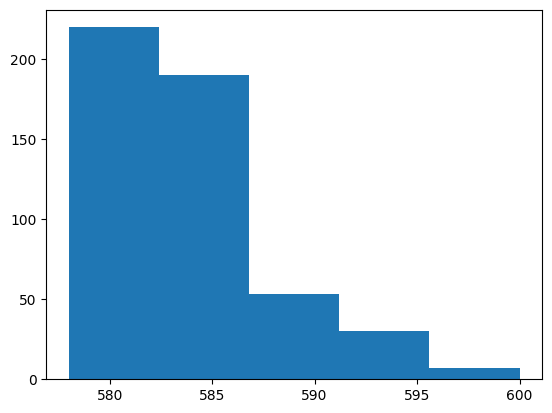

583.568 5.108950577173359


In [18]:
from tqdm import tqdm
QAP_INSTANCE_URL = 'https://qaplib.mgi.polymtl.ca/data.d/nug12.dat'
n, A, B = read_instance(QAP_INSTANCE_URL)


T = 500000
num = 500
radius = 1
alpha = 1.0


costs = np.zeros(num)

for i in tqdm(range((num))):
    costs[i] = simulated_annealing(T, radius, alpha, n, A, B)[T-1]

print(time.time() - t0)

plt.figure()
plt.hist(costs, bins=5)
plt.show()

print(costs.mean(), costs.std())


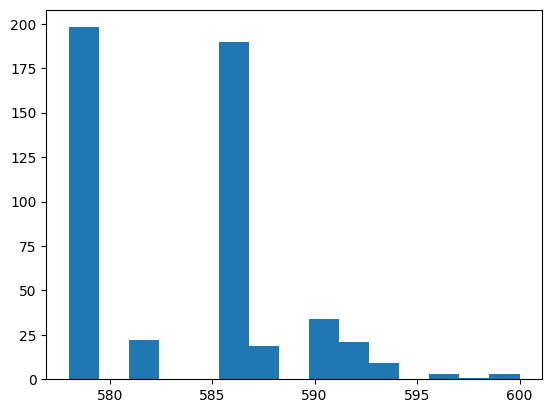

583.568 5.108950577173359


In [19]:
plt.figure()
plt.hist(costs, bins=15)
plt.show()

print(costs.mean(), costs.std())

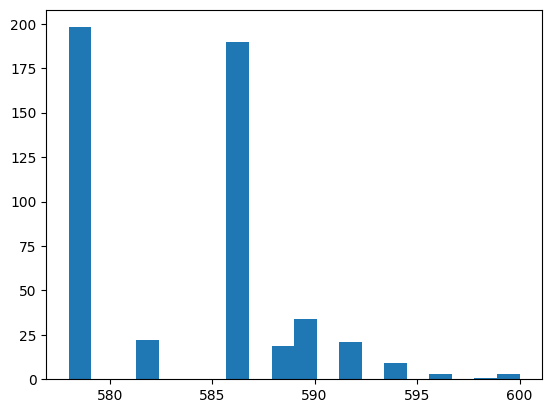

583.568 5.108950577173359


In [20]:
plt.figure()
plt.hist(costs, bins=20)
plt.show()

print(costs.mean(), costs.std())

In [21]:
def simulated_annealing_print(T,radius,alpha, n, A, B):
    t0 = time.time()
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p, n, A, B)
    costs = np.zeros(T)
    times_success=[]
    times_accepted_defeat=[]
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q, n, A, B)
        if(q_cost < p_cost):
            times_success.append(t)
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            times_accepted_defeat.append(t)
            p, p_cost = q, q_cost
        costs[t] = p_cost
    
    print(time.time() - t0, costs.min())

    return times_success, times_accepted_defeat

t1,t2=simulated_annealing_print(T,radius,alpha, n, A, B)

21.293444633483887 578.0


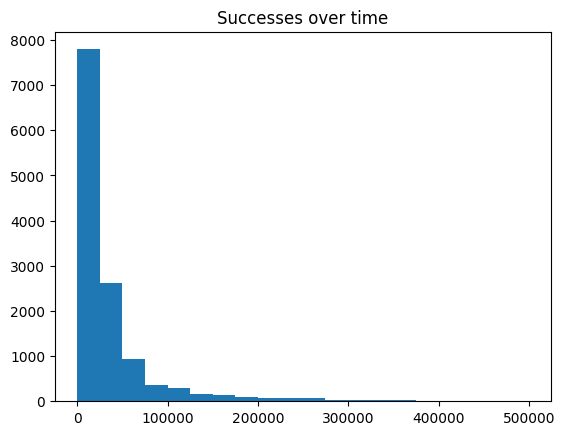

In [22]:
plt.figure()
plt.hist(t1, bins=20)
plt.title("Successes over time")
plt.show()

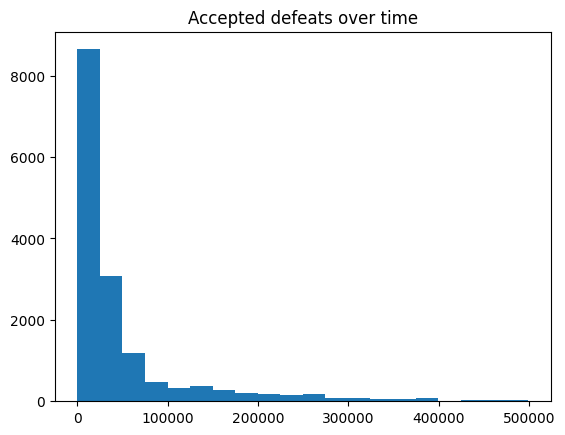

In [23]:
plt.figure()
plt.hist(t2, bins=20)
plt.title("Accepted defeats over time")
plt.show()

35.56817317008972 586.0


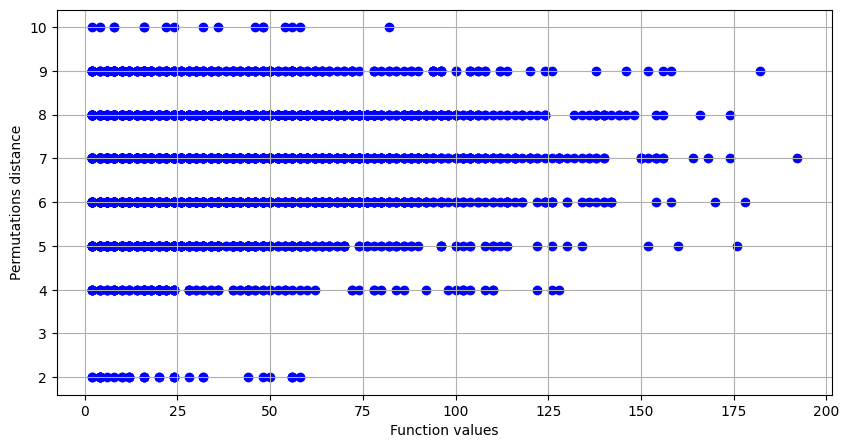

In [24]:
'''
d)Jak można mierzyć odległość między permutacjami? Sprawdź jaka jest zależność
między zmianami wartości funkcji celu f(p) - f(q) w sukcesach, a odległością między
permutacjami p i q. Zilustruj to wykresem.
'''

def hamming_distance(perm1, perm2):
    return sum(p1 != p2 for p1, p2 in zip(perm1, perm2))

def simulated_annealing_d(T,radius,alpha, n, A, B):
    t0 = time.time()
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p, n, A, B)
    costs = np.zeros(T)
    function_values=[]
    perm_dists=[]
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q, n, A, B)
        if(q_cost < p_cost):
            function_values.append(p_cost-q_cost)
            perm_dists.append(hamming_distance(p,q))
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    
    print(time.time() - t0, costs.min())

    return function_values, perm_dists

fv, pd = simulated_annealing_d(T,5,2, n, A, B)


plt.figure(figsize=(10, 5))

plt.scatter(fv, pd, color='blue', marker='o')


plt.xlabel('Function values')
plt.ylabel('Permutations distance')
plt.grid(True)

plt.show()

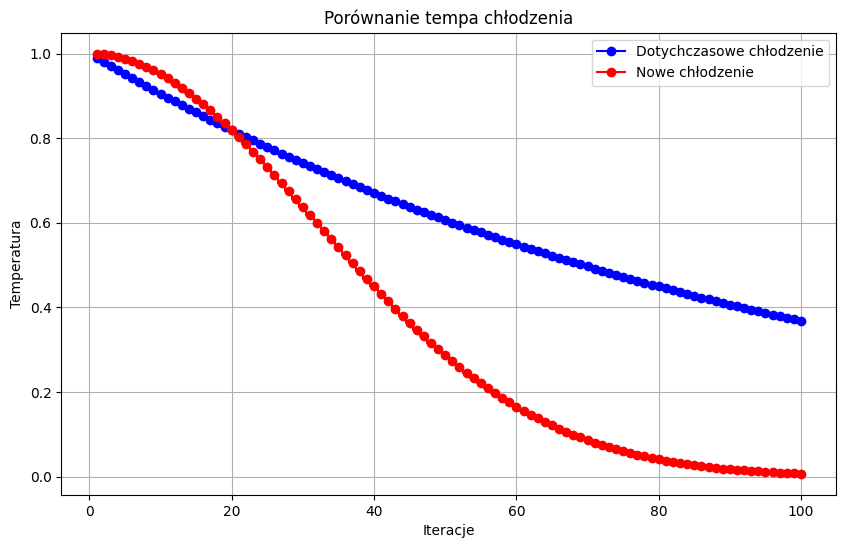

In [26]:
import numpy as np
import matplotlib.pyplot as plt

T_0 = 1.0
T = 100

def linear_cooling(t, T):
    return np.exp(-t / T)


def square_cooling(t, T_0):
    return np.exp(-5*(t / T)**2)

t_values = np.arange(1, T + 1)
linear_temp = linear_cooling(t_values, T)
square_temp = square_cooling(t_values, T_0)

plt.figure(figsize=(10, 6))
plt.step(t_values, linear_temp, label="Dotychczasowe chłodzenie", color='blue', where='mid', marker='o')
plt.step(t_values, square_temp, label="Nowe chłodzenie", color='red', where='mid', marker='o')

plt.title('Porównanie tempa chłodzenia')
plt.xlabel('Iteracje')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True)
plt.show()


20.272246837615967 578.0


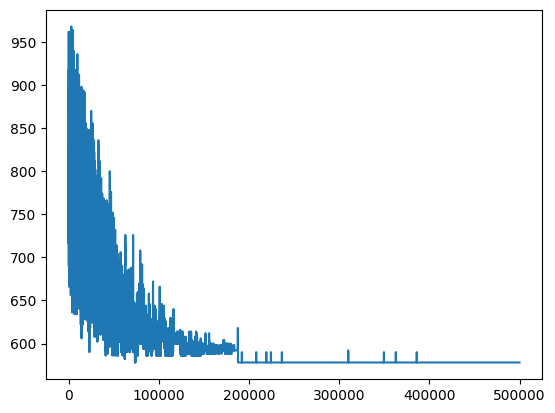

20.935131788253784 578.0


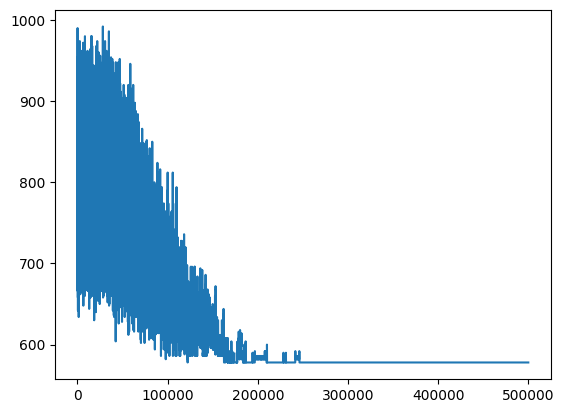

In [27]:
T = 500000
radius = 1
alpha = 1.0


def simulated_annealing_new(T,radius,alpha, n, A, B):
    t0 = time.time()
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p, n, A, B)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q, n, A, B)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * 2*(t / T)**2)):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    
    print(time.time() - t0, costs.min())

    return costs

costs = simulated_annealing(T, radius, alpha, n, A, B)

plt.figure()
plt.plot(costs)
plt.show()

costs = simulated_annealing_new(T, radius, alpha, n, A, B)

plt.figure()
plt.plot(costs)
plt.show()